# Main

## Define variables and import the main library

In [1]:
project_directory = '/home/kramerrs/target_classification'
import os, sys
links_dir = os.path.join(project_directory, 'data', 'all_gene_expression_files_in_target', 'links')
annotation_file = os.path.join(project_directory, 'data', 'gencode.v22.annotation.gtf')
sample_sheet_file = os.path.join(project_directory, 'data', 'gdc_sample_sheet.2020-07-02.tsv')
metadata_file = os.path.join(project_directory, 'data', 'metadata.cart.2020-07-02.json')
if os.path.join(project_directory, 'checkout') not in sys.path:
    sys.path.append(os.path.join(project_directory, 'checkout'))
import target_class_lib as tc

import pysftp
import os
import pickle

import requests as rq
from requests_kerberos import HTTPKerberosAuth
import json as js

## Load the data downloaded from the GDC Data Portal

In [2]:
df_samples, df_counts = tc.load_gdc_data(sample_sheet_file, metadata_file, links_dir)

Reading pickle file /home/kramerrs/target_classification/data/gdc_data.pkl...


## Calculate the FPKM and FPKM-UQ dataframes, and check them with known values if the needed datafiles are present

In [3]:
df_counts.shape

(1321, 60483)

In [4]:
df_fpkm, df_fpkm_uq = tc.get_fpkm(df_counts, annotation_file, df_samples, links_dir)

Reading pickle file /home/kramerrs/target_classification/data/fpkm_data.pkl...


## Remove from the samples and intensities the samples that correspond to multiple cases (i.e., people)

In [5]:
df_samples, indexes_to_keep, _ = tc.drop_multiperson_samples(df_samples)
df_counts = df_counts.iloc[indexes_to_keep,:]
df_fpkm = df_fpkm.iloc[indexes_to_keep,:]
df_fpkm_uq = df_fpkm_uq.iloc[indexes_to_keep,:]

Dropping the following samples from the samples table:
                                            file list index  \
sample id                                                     
TARGET-30-PANKFE-01A, TARGET-30-PAPUAR-01A             1900   
TARGET-30-PANUKV-01A, TARGET-30-PASUML-01A             3075   
TARGET-30-PAPEAV-01A, TARGET-30-PAPTFZ-01A             3653   
TARGET-30-PASYPX-01A, TARGET-30-PAIXIF-01A             1660   

                                                                             counts file name  \
sample id                                                                                       
TARGET-30-PANKFE-01A, TARGET-30-PAPUAR-01A  71edd401-29be-401e-b2de-f5fdca3964d2.htseq_cou...   
TARGET-30-PANUKV-01A, TARGET-30-PASUML-01A  d5589fcc-c841-43d5-ae2a-ce5ee0914c7e.htseq_cou...   
TARGET-30-PAPEAV-01A, TARGET-30-PAPTFZ-01A  fa6a16c4-9eb9-4f04-a784-1a84f57cb479.htseq_cou...   
TARGET-30-PASYPX-01A, TARGET-30-PAIXIF-01A  34253522-71e6-480e-a832-95491686d146.

## Perform exploratory data analysis on the sample labels

/home/kramerrs/Creating-nontechnical-jupyter-notebooks-for-exploratory-data-analysis-and-machine-learning-modeling/target_class_lib.py:563: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  _ = df_samples.hist(ax=ax)


Non-numeric columns with all unique values (1317 of them), with sample values:

 . counts file name        77662ceb-8ac9-4eaf-b997-4ab0dd727065.htseq.counts.gz
 . file id                 0f69bbbd-4608-4ce7-bfa6-a7b098709bfe
 . entity_submitter_id     TARGET-20-PANPLS-03A-04R
 . sample id               TARGET-20-PANPLS-03A

Non-numeric columns with uniform values:

 . contamination_error     None
 . contamination           None
 . state                   released
 . platform                Illumina

Non-numeric columns with non-unique and non-uniform values:

 . project id              9 

TARGET-ALL-P2    519
TARGET-AML       187
TARGET-NBL       157
TARGET-WT        136
TARGET-ALL-P3    135
TARGET-OS         88
TARGET-RT         70
TARGET-CCSK       13
TARGET-ALL-P1     12
Name: project id, dtype: int64 

 . case id                 1188 

TARGET-15-SJMPAL042946    3
TARGET-15-SJMPAL016342    2
TARGET-10-PAPGFP          2
TARGET-10-PAPNMY          2
TARGET-15-SJMPAL041119    2
        

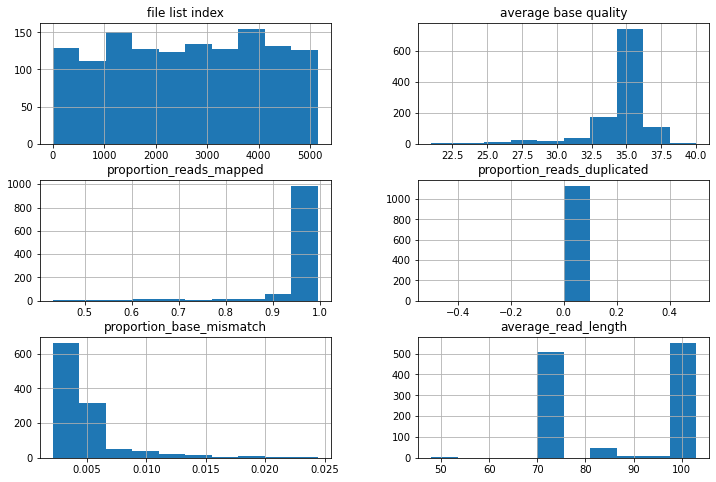

In [6]:
tc.eda_labels(df_samples)

## Plot histograms of the numerical columns of the samples/labels before and after cutoffs are applied, and print out a summary of what was removed

/home/kramerrs/Creating-nontechnical-jupyter-notebooks-for-exploratory-data-analysis-and-machine-learning-modeling/target_class_lib.py:448: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  ax_hist = df_samples.hist(ax=ax)


There are 64 bad values in the "average base quality" plot
There are 61 bad values in the "proportion_base_mismatch" plot
There are 54 bad values in the "proportion_reads_mapped" plot
Most bad values are overlapping; taken together, there are 89 bad values
We should likely use these cutoffs to remove the bad samples; this will only remove 6.8% of the data, leaving 1228 good samples
See for example the two generated images: the first is the original data with the cutoffs plotted in red, and the second is the filtered data with the cutoffs applied


/home/kramerrs/Creating-nontechnical-jupyter-notebooks-for-exploratory-data-analysis-and-machine-learning-modeling/target_class_lib.py:502: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  _ = df_samples.iloc[valid_ind,:].hist(ax=ax)


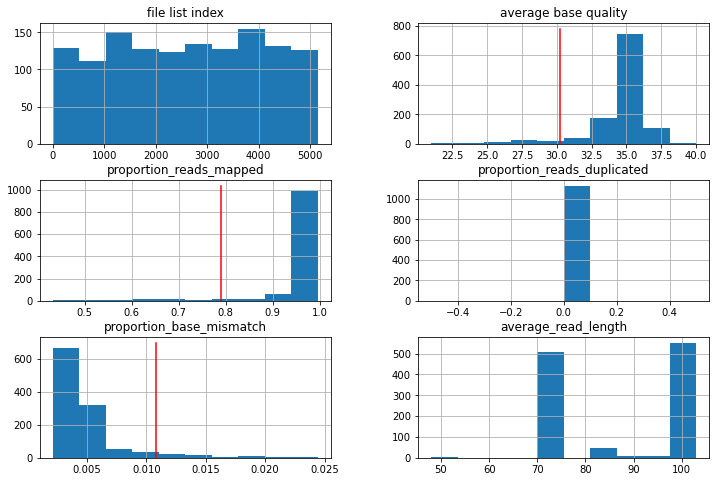

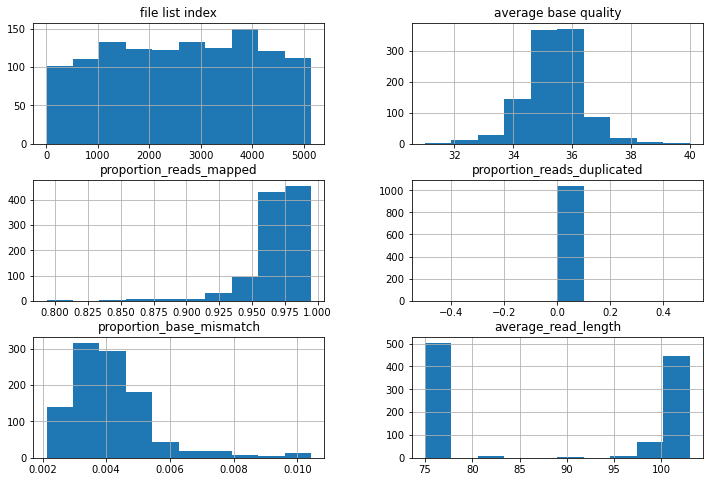

In [7]:
df_samples, indexes_to_keep = tc.remove_bad_samples(df_samples)
df_counts = df_counts.iloc[indexes_to_keep,:]
df_fpkm = df_fpkm.iloc[indexes_to_keep,:]
df_fpkm_uq = df_fpkm_uq.iloc[indexes_to_keep,:]

## Perform exploratory data analysis on the filtered sample labels

/home/kramerrs/Creating-nontechnical-jupyter-notebooks-for-exploratory-data-analysis-and-machine-learning-modeling/target_class_lib.py:563: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  _ = df_samples.hist(ax=ax)


Non-numeric columns with all unique values (1228 of them), with sample values:

 . counts file name        7668ff7c-e237-449a-a413-c0b797c9bb8e.htseq_counts.txt.gz
 . file id                 13bb11da-5897-44a5-ade2-7ae8d2f7b4ca
 . entity_submitter_id     TARGET-10-PASRMM-09A-01R
 . sample id               TARGET-10-PASRMM-09A

Non-numeric columns with uniform values:

 . contamination_error     None
 . contamination           None
 . state                   released
 . platform                Illumina

Non-numeric columns with non-unique and non-uniform values:

 . project id              9 

TARGET-ALL-P2    518
TARGET-AML       187
TARGET-NBL       143
TARGET-WT        136
TARGET-ALL-P3    135
TARGET-RT         69
TARGET-OS         24
TARGET-CCSK       13
TARGET-ALL-P1      3
Name: project id, dtype: int64 

 . case id                 1099 

TARGET-15-SJMPAL042946    3
TARGET-10-PARLAF          2
TARGET-20-PARYFN          2
TARGET-10-PARJSR          2
TARGET-50-PALFME          2
    

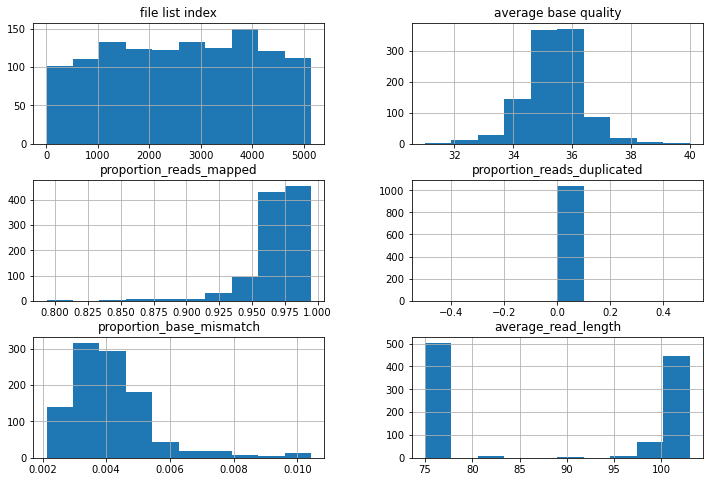

In [8]:
tc.eda_labels(df_samples)

## Print some random data for us to spot-check in the files themselves to manually ensure we have a handle on the data arrays

In [9]:
tc.spot_check_data(df_samples, df_counts, df_fpkm, df_fpkm_uq)

Sample TARGET-10-PARJLA-09B (TARGET-ALL-P2, Primary Blood Derived Cancer - Bone Marrow) should have a counts value of 74 for gene ENSG00000267474.1
Sample TARGET-10-PARFLV-09A (TARGET-ALL-P2, Primary Blood Derived Cancer - Bone Marrow) should have a counts value of 16847 for gene ENSG00000090238.10
Sample TARGET-20-PAPAWN-09A (TARGET-AML, Primary Blood Derived Cancer - Bone Marrow) should have a counts value of 1 for gene ENSG00000242061.1
Sample TARGET-10-PAPKNJ-09B (TARGET-ALL-P2, Primary Blood Derived Cancer - Bone Marrow) should have a counts value of 64 for gene ENSG00000226278.1
Sample TARGET-30-PARZIP-01A (TARGET-NBL, Primary Tumor) should have a FPKM value of 0.3847874579236099 for gene ENSG00000254463.1
Sample TARGET-30-PATHKB-01A (TARGET-NBL, Primary Tumor) should have a FPKM value of 0.9076299559096883 for gene ENSG00000230724.8
Sample TARGET-10-PASSRP-09A (TARGET-ALL-P2, Primary Blood Derived Cancer - Bone Marrow) should have a FPKM value of 0.05682111904387799 for gene ENS

## Calculate the TPM using the counts and gene lengths
Note I've confirmed sufficient equality using TPM calculation using FPKM and FPKM-UQ

In [10]:
df_tpm = tc.get_tpm(df_counts, annotation_file)

Reading pickle file /home/kramerrs/target_classification/data/annotation_dataframe.pkl...


In [11]:
df_tpm.shape
df_tpm.index = df_tpm.index.str.replace('-', '_')

## Add a labels column based on the project id and sample type columns and show the unique values by decreasing frequency

In [12]:
df_samples['label 1'] = df_samples['project id'] + ', ' + df_samples['sample type']
print(df_samples['label 1'].value_counts())

TARGET-ALL-P2, Primary Blood Derived Cancer - Bone Marrow           379
TARGET-NBL, Primary Tumor                                           135
TARGET-WT, Primary Tumor                                            124
TARGET-AML, Primary Blood Derived Cancer - Bone Marrow              119
TARGET-ALL-P3, Primary Blood Derived Cancer - Bone Marrow           113
TARGET-ALL-P2, Primary Blood Derived Cancer - Peripheral Blood       74
TARGET-ALL-P2, Recurrent Blood Derived Cancer - Bone Marrow          64
TARGET-RT, Primary Tumor                                             63
TARGET-AML, Recurrent Blood Derived Cancer - Bone Marrow             40
TARGET-AML, Primary Blood Derived Cancer - Peripheral Blood          26
TARGET-OS, Primary Tumor                                             24
TARGET-CCSK, Primary Tumor                                           13
TARGET-ALL-P3, Recurrent Blood Derived Cancer - Bone Marrow          12
TARGET-ALL-P3, Primary Blood Derived Cancer - Peripheral Blood  

## Run the variance-stabilizing transformation using DESeq2 using this most-detailed set of labels

In [13]:
#X1, y1 = tc.run_vst(df_counts, df_samples['label 1'], project_directory)

In [14]:
df_samples.index = df_samples.index.str.replace('-', '_')

In [15]:
df_counts.index = df_counts.index.str.replace('-', '_')

In [16]:
#print(X1.shape)
#print(y1.shape)
X1=df_tpm

#y1=
y1=df_samples['label 1']





In [17]:
X1.index.equals(y1.index)


True

In [18]:
X1 = X1.sort_index()

In [19]:
y1 = y1.sort_index()

In [20]:
X1.index.equals(y1.index)

True

## Create and plot PCA and tSNE analyses using the variance-stabilizing-transformed data from DESeq2

In [21]:
# Perform PCA
import sklearn.decomposition as sk_decomp
pca = sk_decomp.PCA(n_components=10)
pca_res = pca.fit_transform(X1.iloc[:,:500])
y1
#pca

sample id
TARGET_10_PAKSWW_03A    TARGET-ALL-P2, Primary Blood Derived Cancer - ...
TARGET_10_PAKSWW_04A    TARGET-ALL-P2, Recurrent Blood Derived Cancer ...
TARGET_10_PAMXHJ_09A    TARGET-ALL-P2, Primary Blood Derived Cancer - ...
TARGET_10_PAMXSP_09A    TARGET-ALL-P2, Primary Blood Derived Cancer - ...
TARGET_10_PANATY_09B    TARGET-ALL-P2, Primary Blood Derived Cancer - ...
                                              ...                        
TARGET_52_PAVDPR_01A                             TARGET-RT, Primary Tumor
TARGET_52_PAVITI_01A                             TARGET-RT, Primary Tumor
TARGET_52_PAVVIT_01A                             TARGET-RT, Primary Tumor
TARGET_52_PAWFBL_01A                             TARGET-RT, Primary Tumor
TARGET_52_PAWFWK_01A                             TARGET-RT, Primary Tumor
Name: label 1, Length: 1228, dtype: object

Top 10 PCA explained variance ratios: [0.88732079 0.04326966 0.0268172  0.01179958 0.00607736 0.00448473
 0.00328348 0.00267709 0.00164926 0.00120166]


Text(0.5, 1.0, 'PCA - variance-stabilizing transformation')

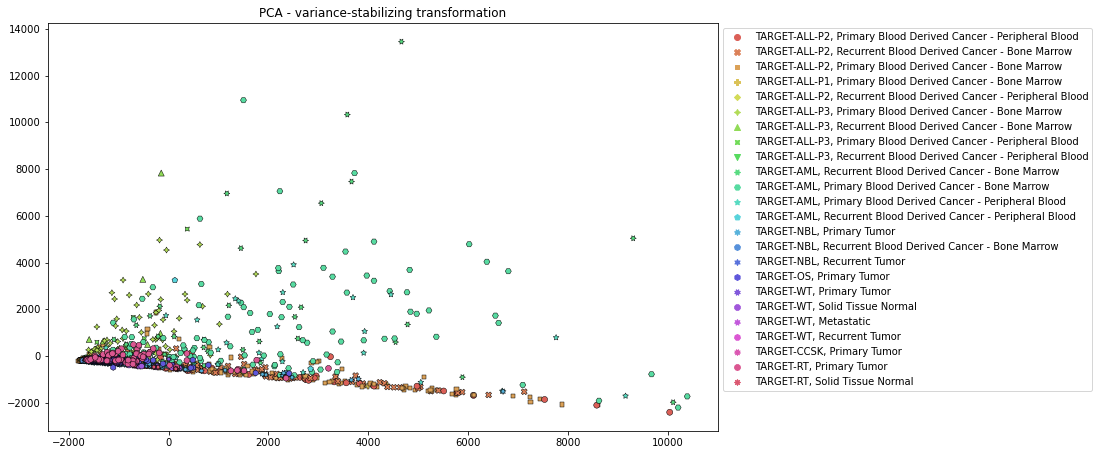

In [22]:
_res = pca.fit_transform(X1.iloc[:,:])
print('Top {} PCA explained variance ratios: {}'.format(10, pca.explained_variance_ratio_))
ax = tc.plot_unsupervised_analysis(pca_res, y1)
ax.set_title('PCA - variance-stabilizing transformation')

Text(0.5, 1.0, 'tSNE - variance-stabilizing transformation')

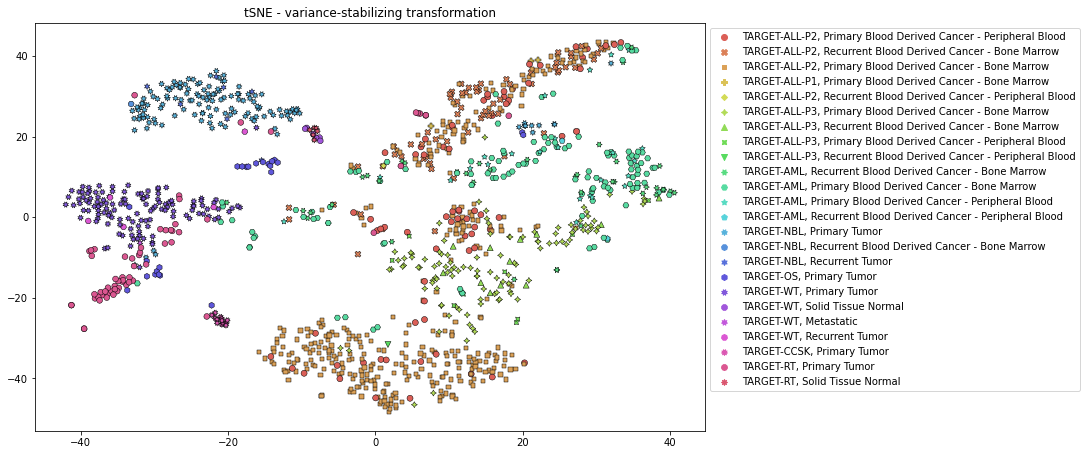

In [23]:
# Perform tSNE analysis
import sklearn.manifold as sk_manif
tsne = sk_manif.TSNE(n_components=2)
tsne_res = tsne.fit_transform(X1.iloc[:,:500])
#tsne_res = tsne.fit_transform(X1.iloc[:,:])
ax = tc.plot_unsupervised_analysis(tsne_res, y1)
ax.set_title('tSNE - variance-stabilizing transformation')

From the above tSNE plot, we find many interesting things, e.g.:

* ALL is spread out in multiple places (all oranges/yellows and early greens), into four main clusters; in particular:
  * ALL/P2/PBDC (both /BM and /PB) is located in three of them
  * ALL/P2/RBDC (i.e., /BM) is basically isolated to one of them
  * ALL/P3 is basically in the fourth cluster
  * Note that even though ALL/P3 is supposed to be the "ambiguously myeloid" one (ALAL, acute leukemia of ambiguous lineage), it is primarily ALL/P2 that seems to sometimes be confused with AML
* AML has its own single cluster
* There are some ALL in an AML cluster and vice versa, and the two corresponding clusters are near each other
* CCSK is very tightly clustered
* NBL has its own cluster, with one RT instance that may be misclassified
* OS is tightly clustered, except for two samples in WT, which may indicate that they are misclassified
* Aside from the one possibly misclassified RT, they are all solidly clustered
* WT is clustered together
* The two normal species are very tightly clustered together
* Note the three kidney tumor types (RT, WT, CCSK) are relatively close together (and are also close to OS and normal)

## Based on the above observations, make a new set of more sensible labels

See comments in each line in the following code block

In [24]:
df_samples['label 2'] = df_samples['label 1'] # initialize the new label (2) to the original, most-detailed label (1)
df_samples['label 2'][df_samples['label 2'].str.contains('normal', case=False, regex=False)] = 'TARGET-Normal' # set to "TARGET-Normal" any label including "normal" in its original name
df_samples['label 2'] = df_samples['label 2'].str.split(pat=', ', expand=True)[0] # otherwise, just set the label to the project ID (see definition of 'label 1' above)
df_samples['label 2'] = df_samples['label 2'].str.split(pat='-', expand=True)[1] # finally, at the same time, both remove "TARGET-" from the labels and, for ALL, remove "-PX", where X={1,2,3}
print(df_samples['label 2'].value_counts()) # print the final labels counts

ALL       656
AML       187
NBL       143
WT        130
RT         63
OS         24
CCSK       13
Normal     12
Name: label 2, dtype: int64


<ipython-input-24-c46653d87a5f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_samples['label 2'][df_samples['label 2'].str.contains('normal', case=False, regex=False)] = 'TARGET-Normal' # set to "TARGET-Normal" any label including "normal" in its original name


## Re-label the unsupervised plots above, just as a quick check of our new labeling scheme

Text(0.5, 1.0, 'tSNE - variance-stabilizing transformation - with new labels')

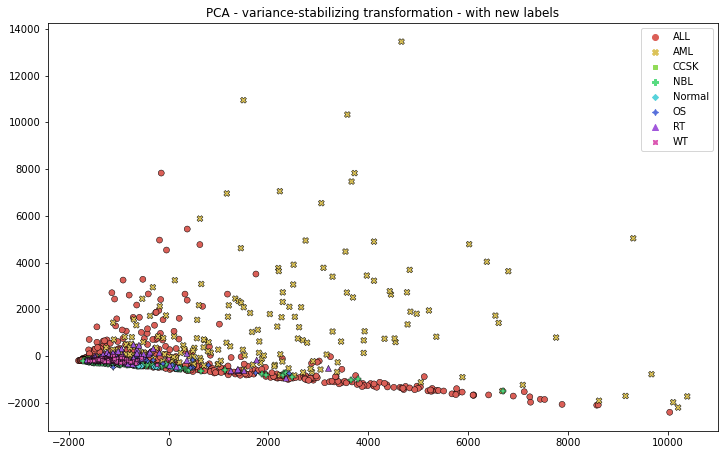

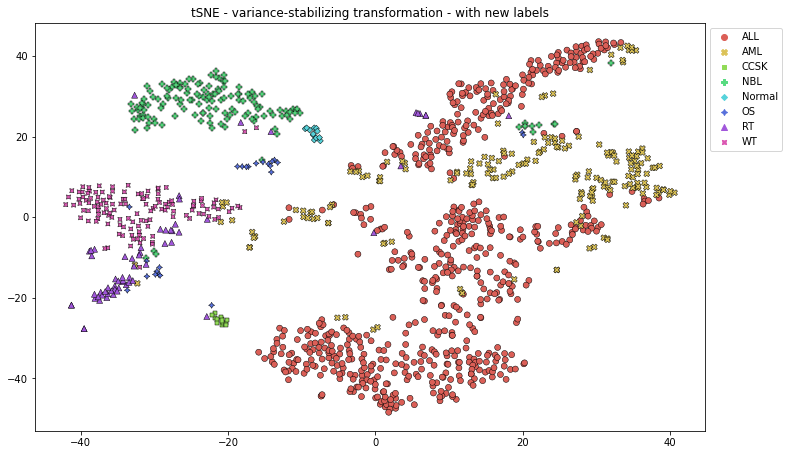

In [25]:
# Define the new labels
y = df_samples['label 2'].copy()
y.index = y.index.str.replace('-', '_')
y = y.loc[y1.index] # order them the same way as the PCA/tSNE results we already calculated

# Redo the plots, with appropriate sorting so that the labels are in alphabetical order
sorting_indexes = y.to_numpy().argsort(axis=0)
ax = tc.plot_unsupervised_analysis(pca_res[sorting_indexes,:], y.iloc[sorting_indexes])
ax.set_title('PCA - variance-stabilizing transformation - with new labels')
ax = tc.plot_unsupervised_analysis(tsne_res[sorting_indexes,:], y.iloc[sorting_indexes])
ax.set_title('tSNE - variance-stabilizing transformation - with new labels')

Note that had we not previously plotted the most detailed set of labels, we would have been left forever wondering why the two distinct clusters of AML data.

## Now actually run the variance-stabilizing transformation using DESeq2 on the re-labeled dataset

In [26]:
#X2, y2 = tc.run_vst(df_counts, df_samples['label 2'], project_directory)

In [27]:
#Revert to TPM
X2 = df_tpm

In [28]:
X2 = X2.sort_index()

In [29]:
y2 = df_samples['label 1']
#df_tpm

In [30]:
X2.index.equals(y2.index)

True

## Run PCA and tSNE on the new dataset

Top 10 PCA explained variance ratios: [0.5199171  0.16093133 0.1178075  0.05516915 0.04221358 0.023743
 0.01139118 0.01041395 0.00876662 0.00721161]


Text(0.5, 1.0, 'tSNE - variance-stabilizing transformation')

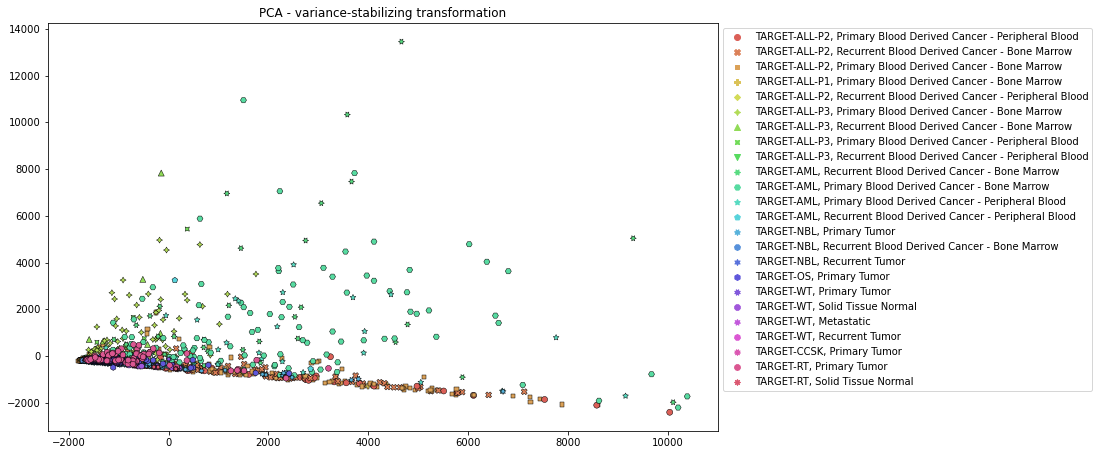

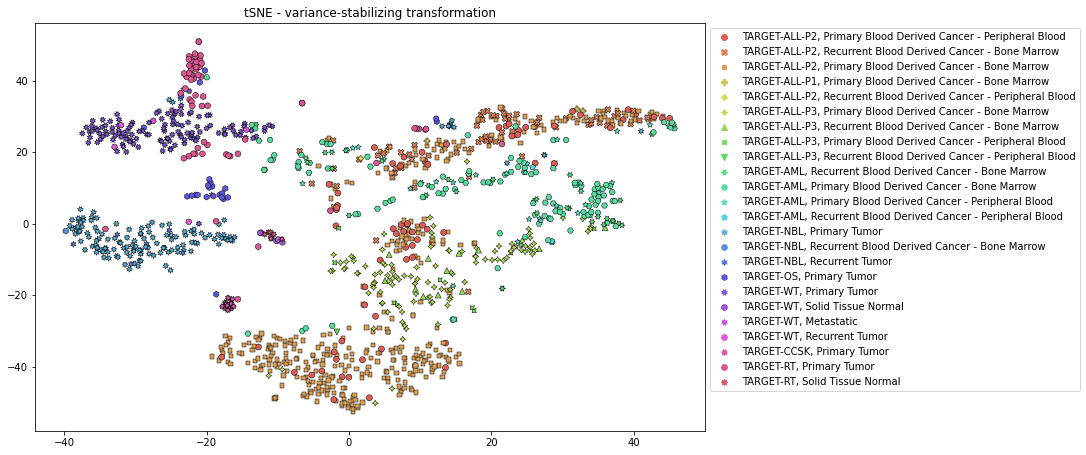

In [31]:
# Perform PCA
import sklearn.decomposition as sk_decomp
pca = sk_decomp.PCA(n_components=10)
pca_res = pca.fit_transform(X2.iloc[:,:500])
print('Top {} PCA explained variance ratios: {}'.format(10, pca.explained_variance_ratio_))
ax = tc.plot_unsupervised_analysis(pca_res, y2)
ax.set_title('PCA - variance-stabilizing transformation')

# Perform tSNE analysis
import sklearn.manifold as sk_manif
tsne = sk_manif.TSNE(n_components=2)
tsne_res = tsne.fit_transform(X2.iloc[:,:500])
ax = tc.plot_unsupervised_analysis(tsne_res, y2)
ax.set_title('tSNE - variance-stabilizing transformation')

## Create a figure helping to explore the extent of sampling each unique label in the dataset (i.e., each group)

In [32]:
#fig = tc.explore_sample_size(X2, y2, tsne_res, n_range=range(100,601,100))
#fig = tc.explore_sample_size(X2, y2, tsne_res, n_range=[1,3,12,50,100,600])
#fig.savefig(os.path.join(project_directory, 'data', 'exploring_sample_size_100_601_100.png'), facecolor='w', dpi=150)

## Run some random forest classification models on the data, saving the results and plotting the accuracies of the models on the entire input datasets

In [33]:
# Get a reasonable set of sample sizes
possible_n = [x for x in range(1,13)] + [x for x in range(15,46,5*2)] + [x for x in range(50,101,10*2)]

# Determine the samples of just particular types
nbl_or_normal_samples = (y2.isin(['TARGET-RT, Solid Tissue Normal','TARGET-NBL, Recurrent Blood Derived Cancer - Bone Marrow','TARGET-NBL, Recurrent Tumor', 'TARGET-OS, Primary Tumor','TARGET-RT, Solid Tissue Normal'])).to_numpy() | (y2=='Normal').to_numpy() # get samples that are NBL or Normal
aml_or_normal_samples = (y2.isin(['TARGET-AML, Recurrent Blood Derived Cancer - Bone Marrow','TARGET-AML, Primary Blood Derived Cancer - Peripheral Blood','TARGET-AML, Recurrent Blood Derived Cancer - Peripheral Blood'])).to_numpy() | (y2=='Normal').to_numpy() # get samples that are AML or Normal

In [34]:
# Generate the random forest classification models

#todo launch on biowulf

#accuracies, possible_n, rnd_clf_holder = tc.generate_random_forest_models(X2, y2, project_directory, 'tpm_all_classes', ntrials=30, possible_n=possible_n) # all data

In [35]:
# Write the pkl for transfer

dataXfer = [X2, y2, 'tpm_all_classes', 30, possible_n]
with open("data_xfer_for_random_forest.pkl", "wb") as f:
    pickle.dump(dataXfer, f)

#Ftp Copy to the file to helix/biowulf hpc
with pysftp.Connection('helix.nih.gov',os.environ['USER']) as sftp:
    with sftp.cd('jobapi_scripts'):             # temporarily chdir to public
        sftp.put('data_xfer_for_random_forest.pkl')  # upload file to public/ on remote
#accuracies, possible_n, rnd_clf_holder = tc.generate_random_forest_models(X2, y2, project_directory, 'tpm_all_classes', ntrials=30, possible_n=possible_n) # all data

# Put the job in the queue if necessary
DME_TOKEN = os.getenv('DME_TOKEN')
USER = os.getenv('USER')

CredentialException: No password or key specified.

In [ ]:
#if not os.path.exists('data_xfer_results_from_random_forest.pkl'):

url = 'https://hpcjobapi.cit.nih.gov/hpcapi/submit_job'
headers = {'Content-type': 'application/json'}
script='#!/bin/bash\n /data/BIDS-HPC/public/software/conda/envs/r_env/bin/python3.8 /home/kramerrs/target_classification/run_RF.py data_xfer_for_random_forest.pkl data_xfer_results_from_random_forest.pkl\n '
obj = {'partition':'gpu', 'gres':'gpu:p100:1','time-limit':'1-00:00:0','mem-per-cpu':'20','ntasks-per-node':'1','script-body':script}
r = rq.post(url, json=obj,auth=HTTPKerberosAuth(),verify=False)

r.content


In [ ]:
 r.content

In [ ]:
#Ftp Copy from the file to helix/biowulf hpc
with pysftp.Connection('helix.nih.gov',os.environ['USER']) as sftp:
    with sftp.cd('jobapi_scripts'):             # temporarily chdir to public
        sftp.get('data_xfer_results_from_random_forest.pkl')  # upload file to public/ on remote
#accuracies, possible_n, rnd_clf_holder = tc.generate_random_forest_models(X2, y2, project_directory, 'tpm_all_classes', ntrials=30, possible_n=possible_n) # all data

# Read the pkl from the transfer

with open("data_xfer_results_from_random_forest.pkl", "rb") as f:
    [accuracies, possible_n, rnd_clf_holder] = pickle.load(  f)

In [ ]:
accuracies_nbl, possible_n_nbl, rnd_clf_holder_nbl = tc.generate_random_forest_models(X2.iloc[nbl_or_normal_samples,:], y2.iloc[nbl_or_normal_samples], project_directory, 'tpm_nbl_vs_normal', possible_n=possible_n[-10:], ntrials=30) # just NBL/Normal

In [ ]:
accuracies_aml, possible_n_aml, rnd_clf_holder_aml = tc.generate_random_forest_models(X2.iloc[aml_or_normal_samples,:], y2.iloc[aml_or_normal_samples], project_directory, 'tpm_aml_vs_normal', possible_n=possible_n[-10:], ntrials=30) # just AML/Normal

In [ ]:
# Plot the accuracy vs. sample size for each study type
tc.plot_accuracy_vs_sample_size(accuracies, possible_n, 'all classes')
tc.plot_accuracy_vs_sample_size(accuracies_nbl, possible_n_nbl, 'NBL vs. normal')
tc.plot_accuracy_vs_sample_size(accuracies_aml, possible_n_aml, 'AML vs. normal')

print('Note a random model would get an accuracy score of 0.125')

## Determine the genes in decreasing order of average feature importance

In [ ]:
# At least for the time being, this step takes a few minutes
important_genes = tc.calculate_average_feature_importance(X2.columns, rnd_clf_holder, num_last_sample_sizes=10)
important_genes_nbl = tc.calculate_average_feature_importance(X2.columns, rnd_clf_holder_nbl, num_last_sample_sizes=10)
important_genes_aml = tc.calculate_average_feature_importance(X2.columns, rnd_clf_holder_aml, num_last_sample_sizes=10)

## Print the top differentiating genes in each study

In [ ]:
print('\nAll data\n', important_genes[:20])
print('\nNBL vs. normal\n', important_genes_nbl[:20])
print('\nAML vs. normal\n', important_genes_aml[:20])

## Notes

* Study feature importance (i.e., which genes matter the most) more closely, both between all classes and between pairs of important classes, e.g., NBL vs. normal
* Run differential expression analyses using DESeq2 to confirm/deny the feature importance analysis here
* Run the same models on the more detailed set of labels (i.e., more detailed design), where confusion matrices would help elucidate how the model does on the different classes, also possibly seeing if there's any correlation with survival, particularly in the ALL groups
* Implement bagging in the random forest model prediction above since I run multiple trials of random forest models
* See [scikit-learn random forest documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_) for note on how to improve upon feature importances
  * Also tweaking the random forest model hyperparameters may help, e.g., selection of features at each node
  * Further, read resources [like this](https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/) to help understand how to best attack imbalanced datasets using random forest
* Potentially run TC1 (supervised deep learning) or P1B1 (autoencoder, unsupervised deep learning)
* Possible overall goals:
  * Determine the genes that best differentiate between cancer types and deeper classes
  * Test supervised learning using new samples, also seeing "See the 'Data quality assessment' section of the vignette for strategies to see if new samples are sufficiently similar to previous datasets." Ensure I can reproduce the VST-transformed data using the supervised R functions I wrote.
* Useful links:
  * [DESeq2 guide](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html)
  * [RNA-Seq workflow](http://master.bioconductor.org/packages/release/workflows/html/rnaseqGene.html)
* Another potential next step is to write up these results
* Based on cursory results changing num_last_sample_sizes to 1, the rankings of at least the promising genes I noted in AML and NBL seem to change a lot. We'd have to justify how we chose the sample sizes that we did. For the time being I should probably trust num_last_sample_sizes set to 10 as I had thought would be best previously, as I chose that based on the stability of the plots. Fortunately, that seems to give better results at least for the two promising genes I noted. Further exploration was always necessary.

## To-do

* Add notes from my last email and Yu's response to here
* To responsd to Yu: What version of the genome are you using? E.g., ENSG00000229164 (their #17 gene, TRAC) isn’t even in GRCh38. Will results change if align against more current version, at least that that GDC uses? There are also old-looking gene names in their list. This appears to correspond to 27 Feb 2014 at latest.
    * Note that GDC isn’t much better (10.2014, 22, N, 03.2015, GRCh38, 22) but at least it’s GRCh38?
* Compare where their top genes rank in our list and vice versa
  * Come up with a scoring system for their data, probably using negative log and normalizing to the best value
* Address and respond to the rest of Yu's email

# Scratch